In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import torchvision.transforms.functional as F

from file_manipulations import getSortedFramePaths

In [2]:
# latent_dims = 2
num_epochs = 250
batch_size = 32
learning_rate = 1e-4
variational_beta = 1
use_gpu = True

In [3]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [4]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [5]:
image_path = "./Dance Data/SkeletonDataClean/Skeleton/Basic/"

In [6]:
composed_transform = torchvision.transforms.Compose([transforms.Resize(64), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

In [7]:
# Real
class DanceFrameDataset(Dataset):
    def __init__(self, image_path, transforms):
        self.transforms = transforms
        self.image_path = image_path
        self.image_names = getListOfFiles(self.image_path)
        print(len(self.image_names))
    def __len__ (self):
        return len(self.image_names)
    def __getitem__(self, idx):
        image_location = self.image_names[idx]
        image = Image.open(image_location)
        image = self.transforms(image)
        return (image > 0.5).float()

In [8]:
# # # Encoded
# class DanceFrameDataset(Dataset):
#     def __init__(self, image_path, transforms):
#         self.transforms = transforms
#         self.image_path = image_path
#         self.image_names = getListOfFiles(self.image_path)
#     def __len__ (self):
#         return len(self.image_names)
#     def __getitem__(self, idx):
#         image_location = self.image_names[idx]
#         image = Image.open(image_location)
#         image = self.transforms(image)
#         image = (image > 0.5).float().to(device)
#         with torch.no_grad():
#             image_enc = vae.encoder(torch.unsqueeze(image, 0))[0]
#             image_dec = vae.decoder(image_enc)
#         return image_dec[0], image

In [9]:
frame_dataset = DanceFrameDataset(image_path, composed_transform)

63182


In [10]:
frame_loader = DataLoader(dataset=frame_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

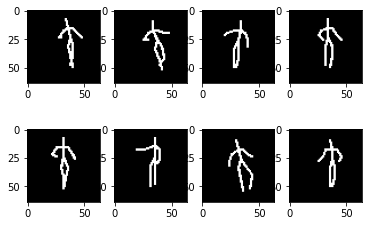

In [11]:
frames = next(iter(frame_loader))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(frames[i].cpu().view(64, 64), cmap="gray")

In [12]:
frames.shape

torch.Size([32, 1, 64, 64])

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv_1 = nn.Conv2d(1, 2, kernel_size=4, stride=2, padding=1)
        self.conv_2 = nn.Conv2d(2, 4, kernel_size=4, stride=2, padding=1)
        self.conv_3 = nn.Conv2d(4, 8, kernel_size=4, stride=2, padding=1)
        self.conv_4 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
    
        self.fc_mu = nn.Linear(in_features=8 * 8 * 8, out_features=256)
        self.fc_logvar = nn.Linear(in_features=8 * 8 * 8, out_features=256)
        
        
    def forward(self, x):
        # b, 1, 64, 64
        x = self.conv_1(x)
        # b, 2, 32, 32
        x = self.conv_2(x)
        # b, 4, 16, 16
        x = self.conv_3(x)
        # b, 8, 8, 8
#         x = self.conv_4(x)
#         # b, 16, 8, 8
        
        x = torch.flatten(x, start_dim=1)
        # b, 1024
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        
        return x_mu, x_logvar

In [14]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv_trans_1 = nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1)
        self.conv_trans_2 = nn.ConvTranspose2d(4, 2, kernel_size=4, stride=2, padding=1)
        self.conv_trans_3 = nn.ConvTranspose2d(2, 1, kernel_size=4, stride=2, padding=1)
#         self.conv_trans_4 = nn.ConvTranspose2d(2, 1, kernel_size=4, stride=2, padding=1)
        
        self.linear = nn.Linear(256, 8 * 8 * 8)
#         self.conv_trans_5 = nn.ConvTranspose2d(2, 1, kernel_size=4, stride=2, padding=1)
        
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # b, 36
        x = self.linear(x)
        # b, 144
        x = x.view(x.shape[0], 8, 8, 8)
        # b, 8, 8, 8
        x = self.conv_trans_1(x)
        # b, 4, 16, 16
        x = self.conv_trans_2(x)
        # b, 2, 32, 32
        x = self.conv_trans_3(x)
        # b, 1, 64, 64
        
#         x = self.conv_trans_4(x)
#         # b, 1, 128, 128
        x = self.sigmoid(x)
        return x
    

In [15]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [16]:
vae = VariationalAutoencoder()

In [17]:
# batch = next(iter(frame_loader))
# yhat = vae(batch)

In [18]:
# from torchviz import make_dot
# make_dot(yhat, params=dict(list(vae.named_parameters()))).render("rnn_torchviz", format="png")

In [19]:
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [20]:
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 4096), x.view(-1, 4096), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence

In [21]:
vae = VariationalAutoencoder().to(device)

In [22]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [23]:
loss_hist = []

In [24]:
def save_checkpoint (state, file_name="vae_conv.pth.tar"):
    print('Saving Checkpoint')
    torch.save(state, file_name)
def load_checkpoint (checkpoint):
    print('Loading Checkpoint')
    vae.load_state_dict(checkpoint['state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer'])

In [25]:
load_model = True

In [26]:
if load_model:
    load_checkpoint(torch.load('vae_conv.pth.tar'))

Loading Checkpoint


In [27]:
vae.train()

for epoch in range(num_epochs):
    checkpoint = {'state_dict': vae.state_dict()}
    save_checkpoint(checkpoint)
#     train_loss_avg.append(0)
#     num_batches = 0
    for idx, (image_batch) in enumerate(frame_loader):
        optimizer.zero_grad()
        image_batch = image_batch.to(device)
#         image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        
#         num_batches += 1
        loss_hist.append(loss.item())
        if idx % 500 == 0:    
            print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(frame_loader)} Loss: {loss:.4f}")
    
    mean_loss = sum(loss_hist)/len(loss_hist)
    scheduler.step(mean_loss)
    print(f"Epoch [{epoch}/{num_epochs}] Loss: {loss:.4f}")



Saving Checkpoint
Epoch [0/250] Batch 0/1974 Loss: 6716.5068


KeyboardInterrupt: 

In [33]:
torch.save(vae.state_dict(), 'vae_conv.pth')

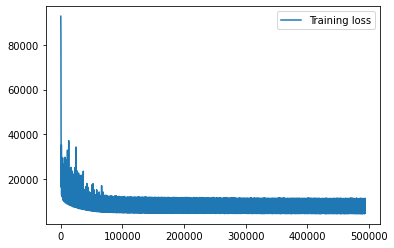

In [34]:
plt.plot(loss_hist, label="Training loss")
plt.legend()
plt.show()

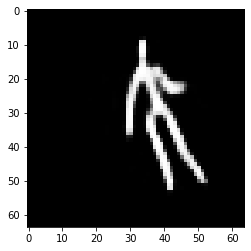

In [28]:
vae.eval()

with torch.no_grad():
    img = frames
    decoded, _, _ = vae(img.to(device))
    plt.imshow(decoded[31].cpu().view(64, 64), cmap="gray")

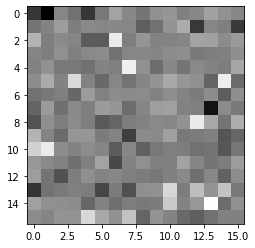

In [29]:
with torch.no_grad():
    img = frames
    mu, _ = vae.encoder(img.to(device))
    plt.imshow(mu[21].cpu().view(16, 16), cmap="gray")

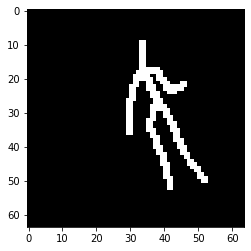

In [30]:
plt.imshow(img[31].cpu().view(64, 64), cmap="gray")

Original images


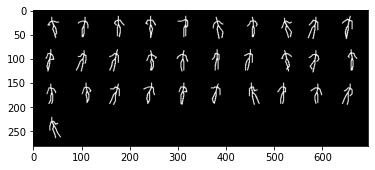

VAE reconstruction:


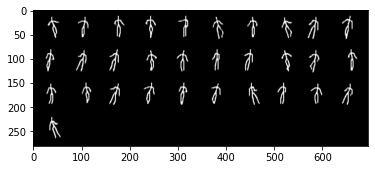

In [31]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images = iter(frame_loader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

In [32]:
frames = next(iter(frame_loader))

In [33]:
image_a = torch.unsqueeze(frames[10], 0)
image_b = torch.unsqueeze(frames[20], 0)

In [34]:
image_a.shape

torch.Size([1, 1, 64, 64])

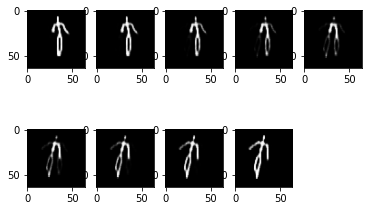

In [35]:
# f, axs = plt.subplots(3, 3, figsize=(5,5)) 
for i in range(1, 10):
    lambda_z = round(0.1 * i, 1)
    with torch.no_grad():
        image_a, image_b = image_a.to(device, dtype=torch.float), image_b.to(device, dtype=torch.float)
        decoded_image = vae.decoder(lambda_z * vae.encoder(image_a)[0] + (1 - lambda_z) * vae.encoder(image_b)[0])
        plt.subplot(2, 5, i)
        plt.imshow(decoded_image.cpu().view(64, 64), cmap="gray")

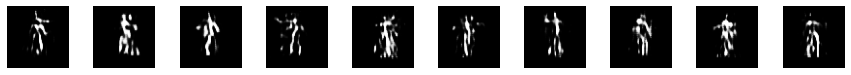

In [36]:
def vae_generate_images(n_to_show=10):
    x = np.random.normal(0,1,size=(n_to_show, 256))
    x = torch.from_numpy(x).float()
    x = x.to(device)

    with torch.no_grad():
        reconst_images = vae.decoder(x)
    
    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')
        sub.imshow(img.cpu(), cmap="gray")

vae_generate_images(n_to_show=10)

In [37]:
image_location = './Dance Data/Skeleton/Basic/gMH/9/frame_6.jpg'
image = Image.open(image_location)
image = composed_transform(image)
image = (image > 0.5).float()
image = torch.unsqueeze(image, dim=0).to(device)

In [38]:
image.shape

torch.Size([1, 1, 64, 64])

In [39]:

with torch.no_grad():
    enc = vae(image)

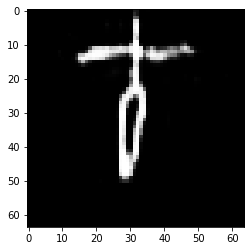

In [40]:
plt.imshow(enc[0].cpu().view(64, 64), cmap="gray")